HOG image plotting related function here. We run it with a small example for some testing:

## Now try with Gabor filters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
root_folder = os.getcwd()
# print(root_folder)
image_path = os.path.join(root_folder, 'images-data-trial')
image_file_list = os.listdir(image_path)

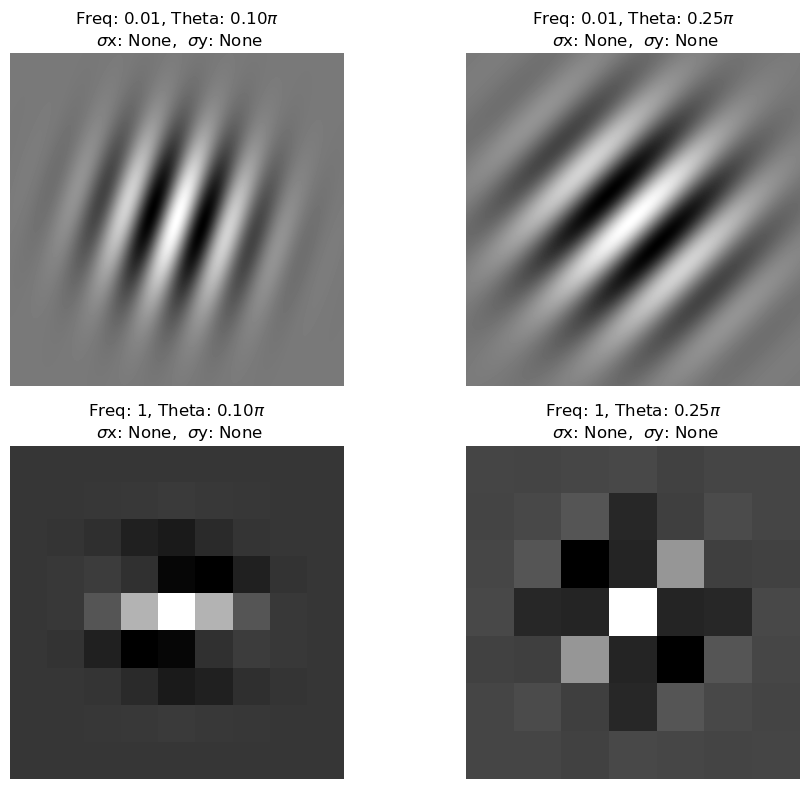

In [2]:
from skimage.filters import sobel_h, sobel_v, sobel
from skimage import data
import numpy as np

# Load an example image
image = data.coins()

# Apply Sobel filter to get the horizontal and vertical edge intensity
edge_sobel_horizontal = sobel_h(image)
edge_sobel_vertical = sobel_v(image)

# Calculate the edge direction
edge_direction = np.arctan2(edge_sobel_vertical, edge_sobel_horizontal)

# Display the edge direction
plt.imshow(edge_direction, cmap='hsv')  # HSV color map to better visualize angles
plt.title('Edge Directions')
plt.colorbar()
plt.show()


### Some plotting here for exploratory and debugging purposes

MemoryError: 

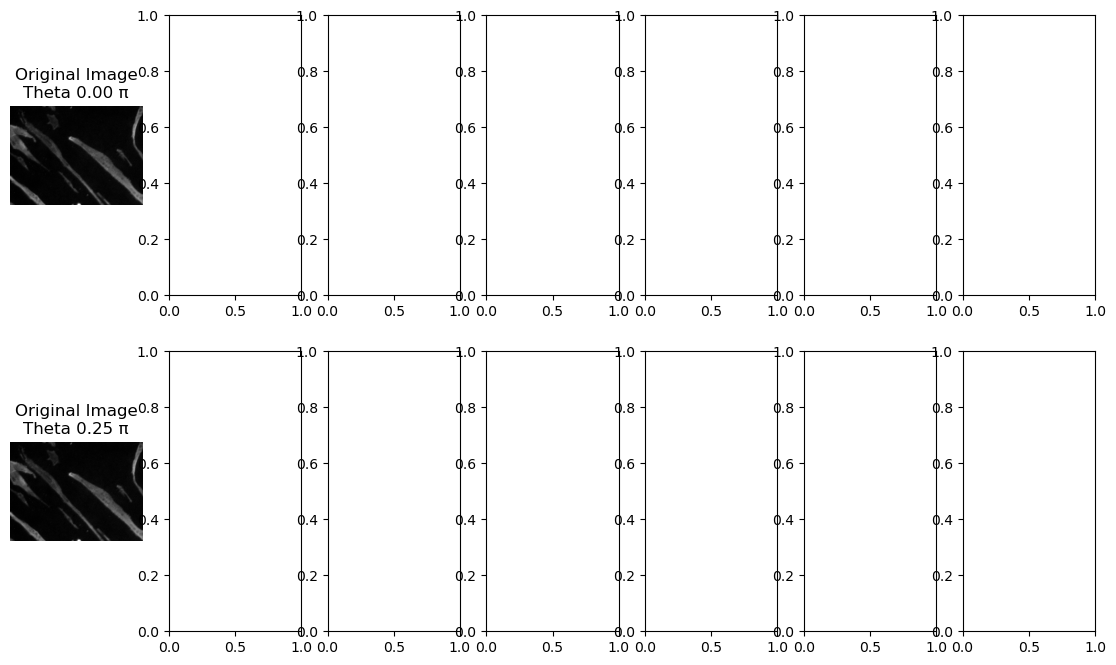

In [3]:
image_file_list = os.listdir(image_path)
origin_plot = True
n_thetas_to_plot = 2

from pipeline_utils import load_and_prepare_image

for image_file in image_file_list[3:4]:
    
    image = load_and_prepare_image(image_path, image_file)

    if image.shape[0]*image.shape[1] > 800*600: # rescale big images to something smaller to gain time (for now)
        print('original size:', image.shape)
        image = transform.rescale(image, 0.02, anti_aliasing=True,
                                channel_axis=-1, mode='reflect', anti_aliasing_sigma=None)
        print('new size:', image.shape)

    image = image[:,:,1] if image.shape[2] > 1 else image #take green channel only

    thetas = np.linspace(0, np.pi/4, n_thetas_to_plot, endpoint=True)
    frequencies = [0.01, 1, 100]

    n_rows = len(thetas)
    n_freqs = len(frequencies)
    n_cols = 2*n_freqs + (1 if origin_plot else 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 8))

    if origin_plot:
        for i in range(len(thetas)):
            axs[i, 0].imshow(image, cmap='gray')
            axs[i, 0].set_title(f'Original Image\nTheta {thetas[i]/np.pi:.2f} π')
            axs[i, 0].axis('off')

    stats_to_store = ['real', 'imaginary', 'energy']
    gabor_responses = pd.DataFrame([], columns=stats_to_store)

    for i, theta in enumerate(thetas):
        for j, frequency in enumerate(frequencies):
                
                real, imagin = gabor(image, frequency=frequency, theta=theta)
                energy = np.sqrt(real**2 + imagin**2)

                real_energy = np.sum(real**2)
                imagin_energy = np.sum(imagin**2)
                tot_energy = np.sum(energy)

                response = pd.DataFrame([[real, imagin, energy]], columns=stats_to_store)

                pd.concat([gabor_responses, response], axis=0)
                # Plotting the response

                axis_l = axs[i, j+int(origin_plot)]
                axs[i, j+int(origin_plot)].imshow(real, cmap='gray')  # Assuming gabor() returns an image
                axs[i, j+int(origin_plot)].set_title(f'Real Response\n $\lambda$: {frequency}, $\theta$: {theta/np.pi:.2f}π')
                axs[i, j+int(origin_plot)].axis('off')
                axs[i, j+int(origin_plot)].text(0.5, -0.1, f'Real Energy: {real_energy:.3g}',
                                                transform=axis_l.transAxes, ha='center', fontsize=10)

                axis_r = axs[i, n_freqs+j+int(origin_plot)]
                axs[i, n_freqs+j+int(origin_plot)].imshow(imagin, cmap='gray')  # Assuming gabor() returns an image
                axs[i, n_freqs+j+int(origin_plot)].set_title(f'Imag Response\n $\lambda$: {frequency}, $\theta$: {theta/np.pi:.2f}π')
                axs[i, n_freqs+j+int(origin_plot)].axis('off')
                axs[i, n_freqs+j+int(origin_plot)].text(0.5, -0.1, f'Total Energy: {tot_energy:.3g}',
                                                        transform=axis_r.transAxes, ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()


In [4]:
from skimage import transform
from skimage.filters import gabor
import datetime
image_file_list = os.listdir(image_path)
origin_plot = True
n_thetas_to_plot = 30
sub_figs = [8, 8]

from pipeline_utils import load_and_prepare_image

for image_file in image_file_list[:5]:
    
    image = load_and_prepare_image(image_path, image_file)
    image = image[:,:,1] if image.shape[2] > 1 else image #take green channel only
    image = image.astype(np.float32)
    print('loaded:', image_file)
    print('original size:', image.shape)
    t1 = datetime.datetime.now()

    if image.shape[0]*image.shape[1] > 1200*800: # rescale big images to something smaller to gain time (for now)
        image = transform.rescale(image, 0.3, anti_aliasing=True, channel_axis=-1, mode='reflect', anti_aliasing_sigma=None)
        print('new size:', image.shape[0]*image.shape[1])


    thetas = np.linspace(0, 2*np.pi, n_thetas_to_plot, endpoint=False)
    frequencies = [0.01, 0.03, 0.1, 0.3, 1, 3]

    stats_to_store = ['image file', 'section', 'angle (deg)', 'frequency', 'tot_energy', 'real', 'imaginary', 'energy']
    stats_to_store = ['image file', 'section', 'angle (deg)', 'frequency', 'tot_energy']
    gabor_responses = []

    part_index = 0

    if image.shape[0]*image.shape[1] <= 800*600:
         sub_figs[0] = 4
         sub_figs[1] = 4
    if image.shape[0]*image.shape[1] <= 400*300:
         sub_figs[0] = 2
         sub_figs[1] = 2
    if image.shape[0]*image.shape[1] <= 200*150:
         sub_figs[0] = 1
         sub_figs[1] = 1         

    widths = np.linspace(0, image.shape[0], num=sub_figs[0]+1, endpoint=True)
    widths = np.rint(widths).astype(int).tolist() #[0, ...., image_w] (M_0+1 entries)

    heights = np.linspace(0, image.shape[1], num=sub_figs[1]+1, endpoint=True)
    heights = np.rint(heights).astype(int).tolist() #[0, ...., image_h] (M_1+1 entries)
    
    for i in range(len(heights)-1):
        for j in range(len(widths)-1):
            part_index += 1  # Increment to track n parts
            print('Treating image part n*:', part_index)
            sub_image = image[widths[i]:widths[i+1], heights[j]:heights[j+1]]
            
            for theta in thetas:
                for frequency in frequencies:     
                    real, imagin = gabor(sub_image, frequency=frequency, theta=theta)
                    # energy = (real + imagin)**2
                    # real_energy = np.sum(real**2)
                    tot_energy = np.sum(real**2 + imagin**2)

                    # response = [image_file, part_index, theta*180/np.pi, frequency, real, imagin, energy, tot_energy]
                    response = [image_file, part_index, theta*180/np.pi, frequency, tot_energy]
                         
                    # gabor_responses = pd.concat([gabor_responses, response], axis=0)
                    gabor_responses.append(response)

     # finished loops with gabor filters ( image boxes grid, angle theta, frequency)
    t2 = datetime.datetime.now()
    elapsed_seconds = int((t2 - t1).total_seconds())
    mins = elapsed_seconds // 60
    secs = elapsed_seconds % 60
    elapsed_time_formatted = f"{mins}:{secs:02d}"
    print(f"Elapsed time for {image_file} (mm:ss): {mins}:{secs:02d}")

gabor_responses_df = pd.DataFrame(gabor_responses, columns=stats_to_store)
gabor_responses_df.to_csv("Response_data", index=False)

loaded: trial_image_0.tif
original size: (103, 69)
Treating image part n*: 1
loaded: trial_image_00.tif
original size: (103, 69)
Treating image part n*: 1
loaded: trial_image_1.tif
original size: (183, 158)
Treating image part n*: 1
loaded: trial_image_2.tif
original size: (584, 784)
Treating image part n*: 1
Treating image part n*: 2


IndexError: list index out of range

## After generating the data, analyse it here:

In [ ]:
gabor_responses_df = pd.read_csv("Response_data", index_col=[0])
# given image and angle, take average over frequencies and image part ( can be 1, 4, or more parts)
gabor_stats = gabor_responses_df.groupby(['image file', 'angle (deg)'])['tot_energy'].mean().reset_index().rename(columns={'tot_energy': 'avg_tot_energy',
                                                                                                                           'angle (deg)': 'theta'})
gabor_stats.to_csv("Response_energy", index=False)

In [ ]:
image_file_list_run = gabor_stats['image file'].unique()

for image_file in image_file_list_run:

    # Filter data for the current image
    df = gabor_stats[gabor_stats['image file'] == image_file]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=None)
    ax2 = plt.subplot(1, 2, 2, projection='polar')

    image = load_and_prepare_image(image_path, image_file, downsample_factor=2)
    ax1.imshow(image)
    ax1.axis('off')

    theta_radians = np.deg2rad(df['theta'])

    # Create polar plot
    ax2.bar(theta_radians, df['avg_tot_energy'], width=2*np.pi/len(theta_radians), bottom=0)
    ax2.set_title(f'Polar Histogram for {image_file}', va='bottom')
    ax2.set_theta_zero_location('E')  # Set 0 degrees to point to the right ( gabor filter X axis)
    plt.tight_layout()
    plt.show()
